In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

# DDM Performance Comparison

## Objective
Compare the performance of different DDM implementations and explore how hardware backends affect simulation speed.

## Implementations Available
You have three implementations to compare:
- Pure Python: Simple but slow (uses interpreted loops)
- NumPy: Vectorized operations (faster)
- TensorFlow: GPU-accelerated (potentially fastest)

## Assignment Tasks

### Part 1: Basic Performance Comparison
1. Run each implementation with the same parameters (e.g., `n_trials=10000`)
2. Measure and compare execution times
3. Verify that all implementations produce similar results

### Part 2: Hardware Backend Exploration
Test TensorFlow with different hardware backends:

```python
# Force CPU-only execution
tf.config.set_visible_devices([], 'GPU')

# Use GPU if available
tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
```

For Apple Metal acceleration (Mac M1/M2), TensorFlow will automatically use it if available.

### Part 3: Performance Analysis
1. Test with different numbers of trials: [100, 1000, 10000, 100000]
2. Create performance plots showing:
   - Execution time vs. number of trials
   - Speedup factors between implementations
3. Answer these questions:
   - Which implementation is fastest for small vs. large trial counts?
   - How does performance scale with the number of trials?
   - What are the tradeoffs between the different implementations?

### Part 4: Advanced Exploration (Optional)
1. Test different time steps (`dt` values) and their effect on:
   - Performance
   - Result accuracy
2. Compare single (float32) vs. double (float64) precision
3. Investigate memory usage differences between implementations

## Deliverables
Create a Jupyter notebook containing:
- Your timing measurements
- Performance comparison plots
- Brief analysis of your findings

## Helpful Tips
- Use `%timeit` in Jupyter notebooks for more accurate timing
- Remember that the first TensorFlow run includes compilation time
- Reset device configuration between different tests
- Check device placement with: `tf.debugging.set_log_device_placement(True)`

## Important Notes
The TensorFlow implementation will show the most dramatic performance differences between hardware backends, while the Python and NumPy implementations will be mostly affected by CPU performance.


# Functions

In [ ]:
import numpy as np
import tensorflow as tf
import time

def ddm_python(n_trials=1000, max_t=10.0, dt=0.001, drift=0.5, noise=0.1, bound=1.0):
    """
    Basic Drift-Diffusion Model (DDM) simulation in pure Python.
    This is the most intuitive implementation but slowest due to Python's interpreted loops.

    Parameters:
    -----------
    n_trials : int
        Number of simulated trials
    max_t : float
        Maximum decision time in seconds
    dt : float
        Time step for simulation in seconds
    drift : float
        Drift rate (evidence accumulation rate)
    noise : float
        Noise standard deviation (diffusion coefficient)
    bound : float
        Decision boundary (±bound)

    Returns:
    --------
    responses : ndarray
        Array of responses (1=upper bound, 0=lower bound)
    rts : ndarray
        Array of reaction times for each trial in seconds
    """
    responses = []  # Store responses (1=upper bound, 0=lower bound)
    rts = []        # Store reaction times in seconds

    for trial in range(n_trials):
        t = 0.0          # Initialize time at 0
        evidence = 0.0   # Initialize accumulated evidence at 0

        # Simulate until time limit reached or boundary crossed
        while t < max_t:
            # Evidence accumulation with noise (Wiener process):
            # drift*dt = systematic evidence accumulation
            # noise*sqrt(dt)*randn() = Gaussian noise (Brownian motion)
            evidence += drift * dt + noise * np.sqrt(dt) * np.random.randn()

            # Check if evidence hit either boundary
            if abs(evidence) >= bound:
                break  # Decision made, exit loop

            t += dt  # Increment time

        # Record response and reaction time
        responses.append(1 if evidence > 0 else 0)  # 1 if evidence > 0, else 0
        rts.append(t)  # Actual time when decision was made

    return np.array(responses), np.array(rts)

def ddm_optimal(n_trials=1000, max_t=10.0, dt=0.001, drift=0.5, noise=0.1, bound=1.0):
    """
    Optimized NumPy DDM simulation that:
    1. Runs all trials in parallel for full duration
    2. Uses vectorized operations for speed
    3. Finds first crossing time for each trial
    4. Handles both upper and lower bounds

    Parameters:
    -----------
    Same as ddm_python()

    Returns:
    --------
    responses : ndarray (int)
        1=upper bound, 0=lower bound, -1=no decision (timeout)
    rts : ndarray (float)
        Reaction times in seconds
    """
    n_steps = int(max_t / dt)  # Number of time steps

    # Generate all noise terms at once for all trials and time steps
    noise_terms = noise * np.sqrt(dt) * np.random.randn(n_trials, n_steps)

    # Create drift terms matrix (same for all trials)
    drift_terms = np.ones((n_trials, n_steps)) * drift * dt

    # Compute evidence trajectories using cumulative sum (vectorized)
    evidence = np.cumsum(drift_terms + noise_terms, axis=1)

    # Add initial evidence (zeros at t=0)
    evidence = np.column_stack([np.zeros(n_trials), evidence])

    # Find boundary crossings
    crossed_up = evidence >= bound    # Upper boundary crossings
    crossed_down = evidence <= -bound # Lower boundary crossings
    crossed = crossed_up | crossed_down  # Any boundary crossing

    # Find first crossing step for each trial (argmax gives first True index)
    crossing_steps = np.argmax(crossed, axis=1)

    # Calculate reaction times: crossing_step * dt, or max_t if no crossing
    rts = np.where(crossed.any(axis=1),  # If any crossing occurred
                  crossing_steps * dt,   # RT = crossing time
                  max_t)                 # Timeout if no crossing

    # Determine responses: 1=upper, 0=lower, -1=no decision
    responses = np.where(crossed_up.any(axis=1), 1, 0)
    responses[crossing_steps == 0] = -1  # Mark no-decision trials

    return responses, rts

def ddm_tensorflow(n_trials=1000, max_t=10.0, dt=0.001, drift=0.5, noise=0.1, bound=1.0):
    """
    TensorFlow DDM implementation with scoped operations for visualization.
    Uses GPU acceleration if available.

    Parameters:
    -----------
    Same as ddm_python()

    Returns:
    --------
    A TensorFlow function that returns (responses, rts) when called
    """
    n_steps = int(max_t / dt)  # Number of time steps

    @tf.function
    def simulate():
        with tf.name_scope('DDM_Simulation'):
            # Create constants for parameters with descriptive names
            with tf.name_scope('Parameters'):
                n_trials_const = tf.constant(n_trials, dtype=tf.int32, name='n_trials')
                n_steps_const = tf.constant(n_steps, dtype=tf.int32, name='n_steps')
                dt_const = tf.constant(dt, dtype=tf.float32, name='dt')
                drift_const = tf.constant(drift, dtype=tf.float32, name='drift')
                noise_const = tf.constant(noise, dtype=tf.float32, name='noise')
                bound_const = tf.constant(bound, dtype=tf.float32, name='bound')
                max_t_const = tf.constant(max_t, dtype=tf.float32, name='max_t')

            # Generate random noise for all trials and time steps
            with tf.name_scope('Noise_Generation'):
                noise_terms = noise_const * tf.sqrt(dt_const) * tf.random.normal([n_trials, n_steps])

            # Create drift terms: v * dt for each time step
            with tf.name_scope('Drift_Terms'):
                drift_terms = tf.ones([n_trials, n_steps]) * drift_const * dt_const

            # Accumulate evidence over time: X(t) = Σ(v*dt + σ*dW)
            with tf.name_scope('Evidence_Accumulation'):
                evidence = tf.cumsum(drift_terms + noise_terms, axis=1)

            # Add initial condition: evidence starts at 0 at t=0
            with tf.name_scope('Initial_Condition'):
                evidence = tf.pad(evidence, [[0, 0], [1, 0]], constant_values=0.0)

            # Check which trials crossed each boundary
            with tf.name_scope('Boundary_Checks'):
                crossed_up = evidence >= bound_const    # Upper boundary crossings
                crossed_down = evidence <= -bound_const  # Lower boundary crossings
                any_crossing = crossed_up | crossed_down  # Any boundary crossing

            # Calculate response times
            with tf.name_scope('Response_Time_Calculation'):
                rts = tf.where(
                    tf.reduce_any(any_crossing, axis=1),  # If any crossing occurred
                    dt_const * tf.cast(tf.argmax(tf.cast(any_crossing, tf.int32), axis=1), tf.float32),
                    max_t_const  # Timeout value if no crossing
                )

            # Determine responses: 1=upper, 0=lower, -1=no decision
            with tf.name_scope('Response_Determination'):
                responses = tf.where(
                    tf.reduce_any(crossed_up, axis=1),     # If upper boundary was crossed
                    tf.constant(1, dtype=tf.int32),       # Response = 1
                    tf.where(                              # Else check lower boundary
                        tf.reduce_any(crossed_down, axis=1),
                        tf.constant(0, dtype=tf.int32),    # Response = 0
                        tf.constant(-1, dtype=tf.int32)    # No decision
                    )
                )
        return responses, rts

    return simulate

In [ ]:
# import matplotlib.pyplot as plt
# # # Force CPU
# tf.config.set_visible_devices([], 'GPU')

# # Use GPU if available
# # tf.config.set_visible_devices(tf.config.list_physical_devices('GPU'), 'GPU')
# tf_simulate = ddm_tensorflow(10000, drift=0.2, bound=.5)
# start = time.time()
# tf_resp, tf_rts = tf_simulate()
# print(f'Time taken: {time.time() - start:.4f}s')

In [11]:
max_t =  10.0
import numpy as np
import tensorflow as tf
import time
import pandas as pd
from collections import defaultdict

# Implementations (same as before)
def ddm_python(n_trials=1000, max_t=10.0, dt=0.001, drift=0.5, noise=0.1, bound=1.0):
    responses, rts = [], []
    for _ in range(n_trials):
        t, evidence = 0.0, 0.0
        while t < max_t:
            evidence += drift * dt + noise * np.sqrt(dt) * np.random.randn()
            if abs(evidence) >= bound:
                break
            t += dt
        responses.append(1 if evidence > 0 else 0)
        rts.append(t)
    return np.array(responses), np.array(rts)

def ddm_optimal(n_trials=1000, max_t=10.0, dt=0.001, drift=0.5, noise=0.1, bound=1.0):
    n_steps = int(max_t / dt)
    noise_terms = noise * np.sqrt(dt) * np.random.randn(n_trials, n_steps)
    drift_terms = np.ones((n_trials, n_steps)) * drift * dt
    evidence = np.cumsum(drift_terms + noise_terms, axis=1)
    evidence = np.column_stack([np.zeros(n_trials), evidence])
    crossed_up = evidence >= bound
    crossed_down = evidence <= -bound
    crossed = crossed_up | crossed_down
    crossing_steps = np.argmax(crossed, axis=1)
    rts = np.where(crossed.any(axis=1), crossing_steps * dt, max_t)
    responses = np.where(crossed_up.any(axis=1), 1, 0)
    responses[crossing_steps == 0] = -1
    return responses, rts

def ddm_tensorflow(n_trials=1000, max_t=10.0, dt=0.001, drift=0.5, noise=0.1, bound=1.0):
    n_steps = int(max_t / dt)
    @tf.function
    def simulate():
        noise_terms = noise * tf.sqrt(dt) * tf.random.normal([n_trials, n_steps])
        drift_terms = tf.ones([n_trials, n_steps]) * drift * dt
        evidence = tf.cumsum(drift_terms + noise_terms, axis=1)
        evidence = tf.pad(evidence, [[0, 0], [1, 0]], constant_values=0.0)
        crossed_up = evidence >= bound
        crossed_down = evidence <= -bound
        any_crossing = crossed_up | crossed_down
        rts = tf.where(tf.reduce_any(any_crossing, axis=1),
                      dt * tf.cast(tf.argmax(tf.cast(any_crossing, tf.int32), axis=1), tf.float32),
                      max_t)
        responses = tf.where(tf.reduce_any(crossed_up, axis=1),
                            tf.constant(1, dtype=tf.int32),
                            tf.where(tf.reduce_any(crossed_down, axis=1),
                                    tf.constant(0, dtype=tf.int32),
                                    tf.constant(-1, dtype=tf.int32)))
        return responses, rts
    return simulate

def run_experiment():
    # Experiment parameters
    trial_counts = [100, 1000, 10000, 50000]
    results = []

    # Check for GPU availability
    gpus = tf.config.list_physical_devices('GPU')
    has_gpu = len(gpus) > 0

    for n_trials in trial_counts:
        print(f"\nRunning with {n_trials} trials...")

        # Python implementation
        start = time.time()
        py_resp, py_rts = ddm_python(n_trials)
        py_time = time.time() - start
        results.append({
            'n_trials': n_trials,
            'implementation': 'python',
            'time': py_time,
            'mean_rt': np.mean(py_rts),
            'accuracy': np.mean(py_resp)
        })
        print(f"Python: {py_time:.4f}s")

        # NumPy implementation
        start = time.time()
        np_resp, np_rts = ddm_optimal(n_trials)
        np_time = time.time() - start
        results.append({
            'n_trials': n_trials,
            'implementation': 'numpy',
            'time': np_time,
            'mean_rt': np.mean(np_rts[np_rts < max_t]),  # Exclude timeouts
            'accuracy': np.mean(np_resp[np_resp >= 0])   # Exclude no-decision trials
        })
        print(f"NumPy: {np_time:.4f}s")

        # TensorFlow CPU
        tf.keras.backend.clear_session()
        with tf.device('/CPU:0'):
            tf_simulate = ddm_tensorflow(n_trials)
            start = time.time()
            tf_cpu_resp, tf_cpu_rts = tf_simulate()
            tf_cpu_time = time.time() - start
            results.append({
                'n_trials': n_trials,
                'implementation': 'tensorflow_cpu',
                'time': tf_cpu_time,
                'mean_rt': np.mean(tf_cpu_rts.numpy()[tf_cpu_rts.numpy() < max_t]),
                'accuracy': np.mean(tf_cpu_resp.numpy()[tf_cpu_resp.numpy() >= 0])
            })
        print(f"TensorFlow (CPU): {tf_cpu_time:.4f}s")

        # TensorFlow GPU (if available)
        if has_gpu:
            tf.keras.backend.clear_session()
            with tf.device('/GPU:0'):
                tf_simulate = ddm_tensorflow(n_trials)
                start = time.time()
                tf_gpu_resp, tf_gpu_rts = tf_simulate()
                tf_gpu_time = time.time() - start
                results.append({
                    'n_trials': n_trials,
                    'implementation': 'tensorflow_gpu',
                    'time': tf_gpu_time,
                    'mean_rt': np.mean(tf_gpu_rts.numpy()[tf_gpu_rts.numpy() < max_t]),
                    'accuracy': np.mean(tf_gpu_resp.numpy()[tf_gpu_resp.numpy() >= 0])
                })
            print(f"TensorFlow (GPU): {tf_gpu_time:.4f}s")
        else:
            print("TensorFlow (GPU): Not available")

    return pd.DataFrame(results)

# Run the experiment
results_df = run_experiment()

# Print the results DataFrame
print("\n=== Performance Results ===")
print(results_df)

# Save to CSV
results_df.to_csv('ddm_performance_results.csv', index=False)
print("\nResults saved to 'ddm_performance_results.csv'")

# Pivot for better visualization
pivot_df = results_df.pivot(index='n_trials',
                           columns='implementation',
                           values='time')
print("\n=== Timing Comparison (seconds) ===")
print(pivot_df)



Running with 100 trials...
Python: 0.1613s
NumPy: 0.0236s
TensorFlow (CPU): 0.1168s
TensorFlow (GPU): 0.2370s

Running with 1000 trials...
Python: 1.5661s
NumPy: 0.3013s
TensorFlow (CPU): 0.1988s
TensorFlow (GPU): 0.2702s

Running with 10000 trials...
Python: 15.7510s
NumPy: 3.2204s
TensorFlow (CPU): 1.6247s
TensorFlow (GPU): 1.7180s

Running with 50000 trials...
Python: 80.3243s
NumPy: 49.5207s
TensorFlow (CPU): 9.4796s
TensorFlow (GPU): 11.8146s

=== Performance Results ===
    n_trials  implementation       time   mean_rt  accuracy
0        100          python   0.161251  1.992560       1.0
1        100           numpy   0.023586  2.025290       1.0
2        100  tensorflow_cpu   0.116780  2.025900       1.0
3        100  tensorflow_gpu   0.237012  2.024180       1.0
4       1000          python   1.566064  1.985064       1.0
5       1000           numpy   0.301264  2.003675       1.0
6       1000  tensorflow_cpu   0.198844  2.000571       1.0
7       1000  tensorflow_gpu   0.27016

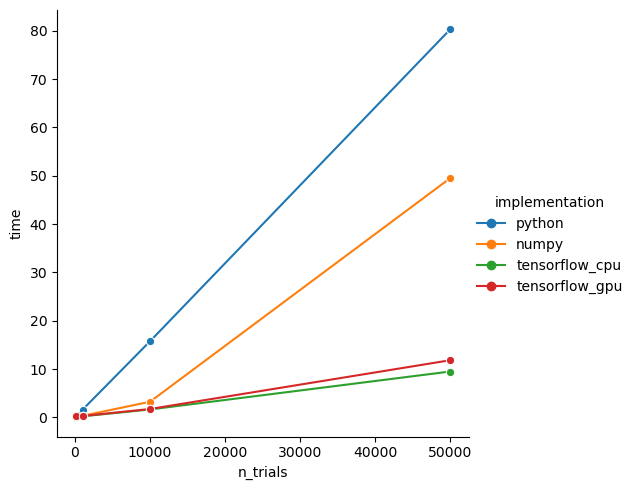

In [16]:
sns.relplot(x='n_trials', y='time', data=results_df.reset_index(), hue='implementation', kind='line', marker='o')